In [1]:
import itertools
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd

import json

from glob import glob
import os

from importlib import reload

import utils
import persim

import tifffile as tf
from KDEpy import FFTKDE
from scipy import ndimage,stats,spatial

In [2]:
nuclei_mask_cutoff = 1
seed = 42
ndims = 3
fs = 12
PP = 6
dpi = 96
minlife = 0.0
rng = np.random.default_rng(seed)
permmethod = stats.PermutationMethod(n_resamples=999, random_state=rng)

Cmap='plasma'
pxs = 75
pxbar = np.s_[-25:-5, 5:5 + pxs]
s = 50
alphaNmin = 0.1
alphaNmax = 10

wong = ['#d81b60', '#b5b5b5', '#6b6b6b', '#000000']
marker = ['D', '8', 's', '^', 'v', 'P', 'X', '*']
color = ['#56b4e9', '#009e73', '#0072b2', '#d55e00', '#cc79a7', '#e69f00']
cmap = ['PuBu_r', 'Greens_r', 'Blues_r', 'Oranges_r', 'RdPu_r', 'YlOrBr_r']
box_params = {'widths':0.75, 'patch_artist':True, 'medianprops':{'lw':3, 'color':'red'} }
#figdst = os.path.expanduser('~') + '/documents/website/mcarto/figs/'
sample = 'D2'

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
ksrc = '../kde/'
isrc = '..' + os.sep + 'infected_focus_summer24' + os.sep 

isrc += sample + os.sep
ksrc += sample + os.sep

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col='ndimage_cellID')
metaecc = pd.read_csv(ksrc + sample + '_nodule_root_eccentricity.csv', index_col='ndimage_cellID')
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv', index_col='gene')
cell_nuc = pd.read_csv(ksrc + sample + '_nuclei_limits.csv')
transcriptomes = np.asarray(list(metatrans['gene']))
metatrans = metatrans.set_index('gene')

Cells = utils.get_range_cell_values(isrc + 'infected_cells_ids.csv', metacell, startval=1)
Cells = np.setdiff1d( Cells, metacell[metacell['number_nuclei'] > 1].index)

Genes = utils.get_range_gene_values(isrc + 'genes_to_focus_infection.csv', transcriptomes, startval=0)
invGenes = dict(zip(Genes, range(len(Genes))))
invCells = dict(zip(Cells, range(len(Cells))))
transfocus = transcell.loc[transcriptomes[Genes], Cells.astype(str)]

wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))
print('Detected',cellnum,'cells')

lnuc, nnuc = ndimage.label(tf.imread(nsrc + sample + '_EDT.tif') < nuclei_mask_cutoff, ndimage.generate_binary_structure(2,1))
print('Detected',nnuc,'nuclei')
wcoords = np.asarray(np.nonzero(~wall))
foo = [ wong[-1], wong[-2] ] + np.repeat(wong[1], nnuc).tolist() + ['#f0f0f0']
cellular_cmap = ListedColormap(foo)

wc = wcoords[:, ~np.all(wcoords%100, axis=0)]

translocs = [None for i in range(len(transcriptomes))]
for i in range(len(transcriptomes)):
    filename = tsrc + sample + os.sep + 'location_corrected_D2_-_' + transcriptomes[i] + '.csv'
    translocs[i] = pd.read_csv(filename, header=None, names=['X', 'Y', 'Z'])
tlocs = pd.concat(translocs)
tcumsum = np.hstack(([0], np.cumsum(metatrans['cyto_number'].values)))

handles = [None for _ in range(len(Genes))]
for i in range(len(handles)):
    handles[i] = mlines.Line2D([], [], mfc=color[i], marker=marker[i], ls='None', mec='k', mew=1, ms=7)

transfocus

Detected 2937 cells
Detected 1365 nuclei


169   188  199  209   224  227  233   235   236  243  ...  \
gene                                                                    ...   
GLYMA_17G195900  1017  2397  727  307  1012  902  832  1286  1518  320  ...   
GLYMA_05G092200   456  1687  637  503   465  481  627   971   684  324  ...   

                 2511  2514  2515  2523  2529  2536  2548  2552  2573  2576  
gene                                                                         
GLYMA_17G195900   809  1299   181   210  1106   366   681   765   574   771  
GLYMA_05G092200   654   818   199   407  1065   417   428   711   345   477  

[2 rows x 918 columns]

In [3]:
level = 'sub'
normtype = 'both'
stepsize = 3
SCALE = 32
bw = 25

sigma = 1
pers_w = 1
pixel_size = 1

zmax = np.max(tlocs['Z']+stepsize)
zbins = np.arange(0, zmax+stepsize, stepsize)

dsrc = isrc + 'G{}_{}level_{}_step{}_bw{}'.format(len(Genes), level, normtype, stepsize, bw) + os.sep
ratios = utils.normalize_counts(transfocus, normtype)

jsonfiles = [ [ None for j in range(ratios.shape[1]) ] for i in range(ratios.shape[0]) ]
gsrc = '../{}level/'.format(level) + sample + os.sep
for i in range(len(jsonfiles)):
    foo = '{}{}/{}_-_{}_p{}_s{}_bw{}_c{:06d}.json'
    for j in range(len(jsonfiles[0])):
        filename = foo.format(gsrc, transcriptomes[Genes[i]],transcriptomes[Genes[i]],level,PP,stepsize,bw,Cells[j])
        if os.path.isfile(filename):
            jsonfiles[i][j] = filename

orig_diags = [ utils.get_diagrams(jsonfiles[i], ndims, remove_inf=True) for i in range(len(jsonfiles))]
orig_diags, rescale, maxlife, focus_dim = utils.normalize_persistence_diagrams(orig_diags, ratios, normtype, SCALE)

kde_max = np.zeros(ratios.size)
for i in range(len(orig_diags)):
    for j in range(len(orig_diags[i])):
        if len(orig_diags[i][j][focus_dim]) > 0:
            kde_max[i*len(orig_diags[i]) + j] = np.max(orig_diags[i][j][focus_dim])

kmax = np.sort(kde_max)[-20]

lt_mask = np.any(maxlife > minlife, axis=2)
gmask, cmask = np.nonzero(lt_mask)

bsummary = pd.DataFrame()
bsummary['gene_ID'] = Genes[gmask]
bsummary['ndimage_ID'] = Cells[cmask]
uq , cts = np.unique(gmask, return_counts=True)
nzcumsum = np.hstack(([0], np.cumsum(cts) ))

if normtype == 'gene':
    diags = [ [ [ rescale[i][0][0]*orig_diags[i][j][k].copy() for k in range(len(orig_diags[i][j])) ] for j in range(len(orig_diags[i])) ] for i in range(len(orig_diags)) ]
elif normtype == 'both':
    diags = [ [ [ rescale*orig_diags[i][j][k].copy() for k in range(len(orig_diags[i][j])) ] for j in range(len(orig_diags[i])) ] for i in range(len(orig_diags)) ]
for i in range(len(diags)):
    for j in range(len(diags[i])):
        for k in range(len(diags[i][j])):
            diags[i][j][k] = np.atleast_2d(diags[i][j][k][ diags[i][j][k][:,1] - diags[i][j][k][:,0] > minlife, : ])

full_lt_coll = [ [None for _ in range(np.sum(lt_mask)) ] for _ in range(ndims) ]
for i in range(len(gmask)):
    for k in range(len(full_lt_coll)):
        d = diags[gmask[i]][cmask[i]][k]
        full_lt_coll[k][i] = np.column_stack( (d[:, 0], d[:, 1] - d[:, 0])  )

maxbirth = 0
for k in range(len(full_lt_coll)):
    for i in range(len(full_lt_coll[k])):
        if len(full_lt_coll[k][i]) > 0:
            b = np.max(full_lt_coll[k][i][:,0])
            if b > maxbirth:
                maxbirth = b

maxbirth

Initial number of life-birth pairs	: 69430

No. of diagrams s.t. H_k had the most persistent component
H_0:	56 [ 3.1% ]
H_1:	137 [ 7.5% ]
H_2:	1643 [ 89.5% ]

Will focus just on dimension k = 2



17.945968549530665

# Bring in persistence images to the party

In [4]:
pi_params = {'birth_range':(0,min([SCALE, int(np.ceil(maxbirth + sigma))] )),
             'pers_range':(0,min([SCALE, int(np.ceil(maxlife[:,:,focus_dim].max()+sigma))])),
             'pixel_size': pixel_size,
             'weight': 'persistence',
             'weight_params': {'n': pers_w},
             'kernel':'gaussian',
             'kernel_params':{'sigma': [[sigma, 0.0], [0.0, sigma]]} }
                       
pimgr = persim.PersistenceImager(**pi_params)
extent = np.array([ pimgr.birth_range[0], pimgr.birth_range[1], pimgr.pers_range[0], pimgr.pers_range[1] ]).astype(int)
full_img = np.zeros((len(full_lt_coll), len(full_lt_coll[0]), extent[1], extent[3]))
for k in range(len(full_img)):
    full_img[k] = np.asarray(pimgr.transform(full_lt_coll[k], skew=False))
full_img[full_img < 0] = 0

# Pipeline figure

In [5]:
method = 'PCA'
hdims = np.array([1,2])
Pname = ' [$' + ' \\oplus '.join(['H_{}'.format(k) for k in hdims]) + '$]'
pname = 'H' + '+'.join(hdims.astype(str))
csvfilename = dsrc + 'scale{}_-_PI_{}_{}_{}_pca_{}.csv'.format(SCALE, sigma, pers_w, pixel_size, pname )
print(csvfilename)
embedding = pd.read_csv(csvfilename)
pca = embedding.iloc[:,2:4].values
Bname = 'KDE bandwidth {}. {}level persistence. PIs {}$\\times${}.'.format(bw, level.title(), SCALE, SCALE)
bname = 'scale{}_-_PI_{}_{}_{}_'.format(SCALE, sigma, pers_w, pixel_size)

../infected_focus_summer24/D2/G2_sublevel_both_step3_bw25/scale32_-_PI_1_1_1_pca_H1+2.csv


In [6]:
steps = 1
llim = int(np.floor(pca[:,0].min()))
rlim = int(np.ceil(pca[:,0].max()))

blim = int(np.floor(pca[:,1].min()))
tlim = int(np.ceil(pca[:,1].max()))
print(llim, tlim, rlim, blim)

yaxis = np.linspace(blim, tlim, int(steps*(tlim - blim))+1)[::-1]
xaxis = np.linspace(llim, rlim, int(steps*(rlim - llim))+1)
AXES = np.meshgrid(yaxis, xaxis, indexing='ij')
grid = np.column_stack([ np.ravel(AXES[i]) for i in range(len(AXES)) ])

dists = spatial.distance.cdist(np.flip(grid, axis=1), pca, metric='euclidean')
mindist = np.min(dists, axis=1)
minmask = mindist < 1/(4*steps)

blim, llim = np.min(grid[minmask], axis=0)
tlim, rlim = np.max(grid[minmask], axis=0)
print(llim, tlim, rlim, blim)

yaxis = np.linspace(blim, tlim, int(steps*(tlim - blim))+1)[::-1]
xaxis = np.linspace(llim, rlim, int(steps*(rlim - llim))+1)
AXES = np.meshgrid(yaxis, xaxis, indexing='ij')
grid = np.column_stack([ np.ravel(AXES[i]) for i in range(len(AXES)) ])

dists = spatial.distance.cdist(np.flip(grid, axis=1), pca, metric='euclidean')
argmin = np.argmin(dists, axis=1)
mindist = np.min(dists, axis=1)
minmask = mindist < 1/(4*steps)
reps = argmin[minmask]
print(reps.shape)

nrow = int((tlim - blim)*steps)+1
ncol = int((rlim - llim)*steps)+1

-2 4 5 -3
-1.0 3.0 4.0 -2.0
(22,)


../infected_focus_summer24/D2/G2_sublevel_both_step3_bw25/scale32_-_PI_1_1_1_H1+2_pca_gridded


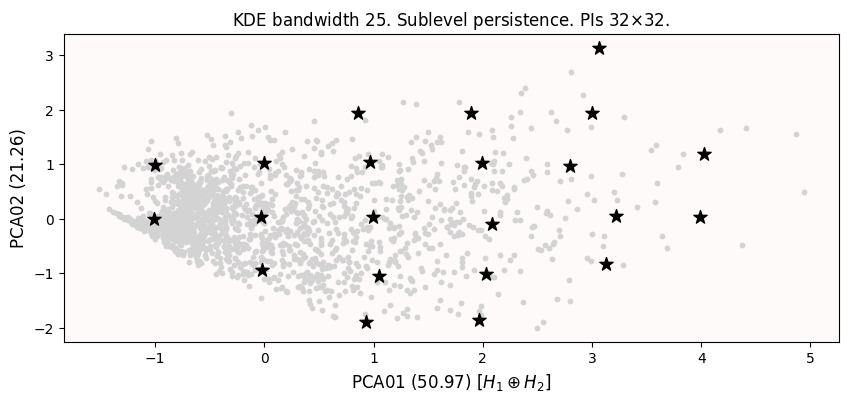

In [10]:
fig, ax = plt.subplots( 1,1, figsize=(10, 4), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].set_title(Bname, fontsize=fs)
ax[i].scatter(pca[:,0], pca[:,1], c='lightgray', marker='o', s=10, alpha=1, zorder=1)
ax[i].scatter(pca[reps,0], pca[reps,1], c='k', marker='*', s=100, alpha=1, zorder=2)
ax[i].set_xlabel(embedding.columns[2]+Pname, fontsize=fs)
ax[i].set_ylabel(embedding.columns[3], fontsize=fs)
ax[i].set_facecolor('snow')
filename = dsrc + bname + pname + '_pca_gridded'
print(filename)
#plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

In [34]:
lt_coll = [None for _ in range(len(reps))]
for i in range(len(lt_coll)):
    foo = [full_lt_coll[k][reps[i]].copy() for k in hdims]
    for j in range(1, len(hdims)):
        foo[j][:,0] += j*full_img.shape[2]
    lt_coll[i] = np.vstack(foo)
    
img = np.hstack(full_img[hdims])[reps]
vmax = np.quantile(img[img > 0], 0.99)

../infected_focus_summer24/D2/G2_sublevel_both_step3_bw15/scale24_-_PI_1_1_1_pca_H1+2_PI_sample


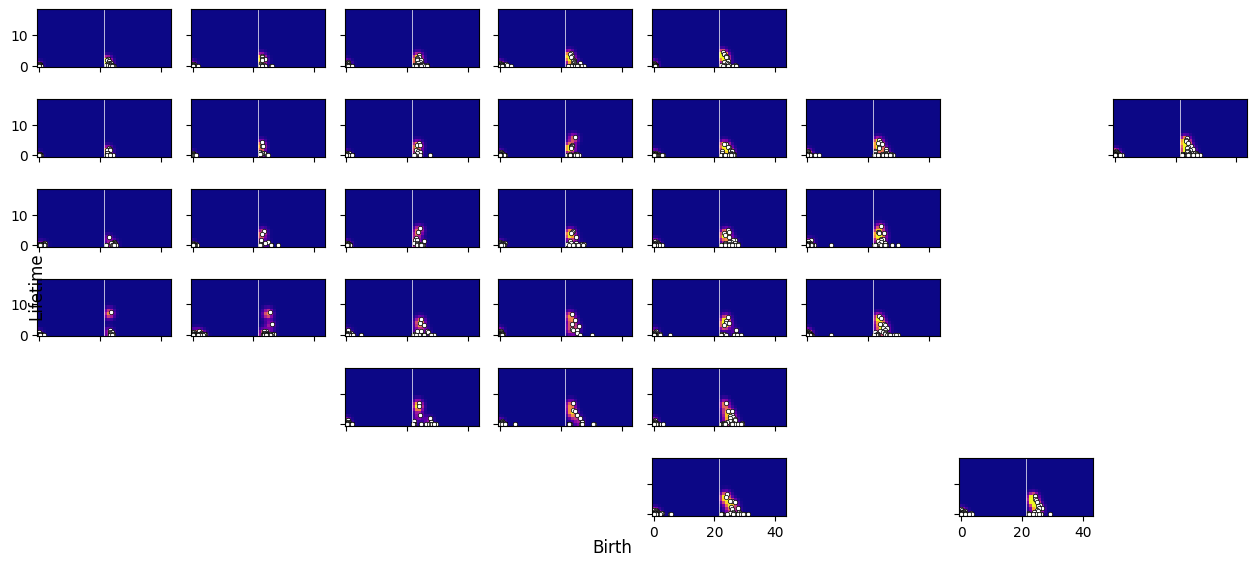

In [16]:
fig, ax = plt.subplots( nrow, ncol, figsize=(13, (0+0.5*len(hdims))*nrow), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel();

for i, j in enumerate(np.nonzero(minmask)[0]):
    ax[j].imshow(img[i].T, cmap=Cmap, vmin=0, vmax=vmax, origin='lower')
    for k in range(1, len(hdims)):
        ax[j].axvline(k*full_img.shape[2] - .5, c='white', lw=0.5)
    ax[j].scatter(lt_coll[i][:,0], lt_coll[i][:,1], c='w', marker='o', s=10, edgecolor='k', linewidth=0.5)

foo = np.nonzero(~minmask)[0]
if len(foo) > 0:
    for j in foo:
        fig.delaxes(ax[j])

fig.supxlabel('Birth', fontsize=fs, y=0.05)
fig.supylabel('Lifetime', fontsize=fs, x=0.05)
fig.tight_layout();
filename = dsrc + bname + pname + '_PI_sample'
print(filename)
#plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

In [36]:
KDE, hcells, hcoords, hextent, hzhist = [ [None for _ in range(len(reps))] for _ in range(5) ]

for i in range(len(KDE)):
    cidx = embedding.loc[reps[i], 'ndimage_ID']
    cmask = label[ translocs[ embedding.loc[reps[i], 'gene_ID']]['Y'], translocs[embedding.loc[reps[i], 'gene_ID']]['X'] ] == cidx
    hcoords[i] = translocs[embedding.loc[reps[i], 'gene_ID']].iloc[cmask].values.T
    hzhist[i], _ = np.histogram(hcoords[i][2], bins=zbins, density=True)

    hcells[i], hextent[i] = utils.get_cell_img(cidx, metacell, label, lnuc, nnuc, pxbar=False)
    
    axes, grid, kdegmask, cgrid, outside_walls = utils.cell_grid_preparation(cidx, hcells[i], hextent[i], zmax, stepsize, cell_nuc)
    
    kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(hcoords[i].T).evaluate(grid)
    kde = kde[kdegmask]/(np.sum(kde[kdegmask])*(stepsize**len(hcoords[i])))
    kde[outside_walls] = 0
    kde = kde/(np.sum(kde)*(stepsize**len(hcoords[i])))
    
    KDE[i] = kde.reshape( list(map(len, axes))[::-1], order='F')
    if i%10 == 0:
        print(i)

for cell in hcells:
    cell[pxbar] = -1

hkdes = [ KDE[i].copy() * ratios[invGenes[embedding.loc[reps[i], 'gene_ID']]][ invCells[embedding.loc[reps[i], 'ndimage_ID']] ] for i in range(len(KDE))]
if normtype == 'gene':
    for i in range(len(hkdes)):
        hkdes[i] *= rescale[invGenes[embedding.loc[reps[i], 'gene_ID']]][0][0]

hzlevel = np.array(list(map(np.argmax, hzhist)))

0
10
20


../infected_focus_summer24/D2/G2_sublevel_both_step3_bw30/scale16_-_PI_1_1_1_H1+2_cell_sample


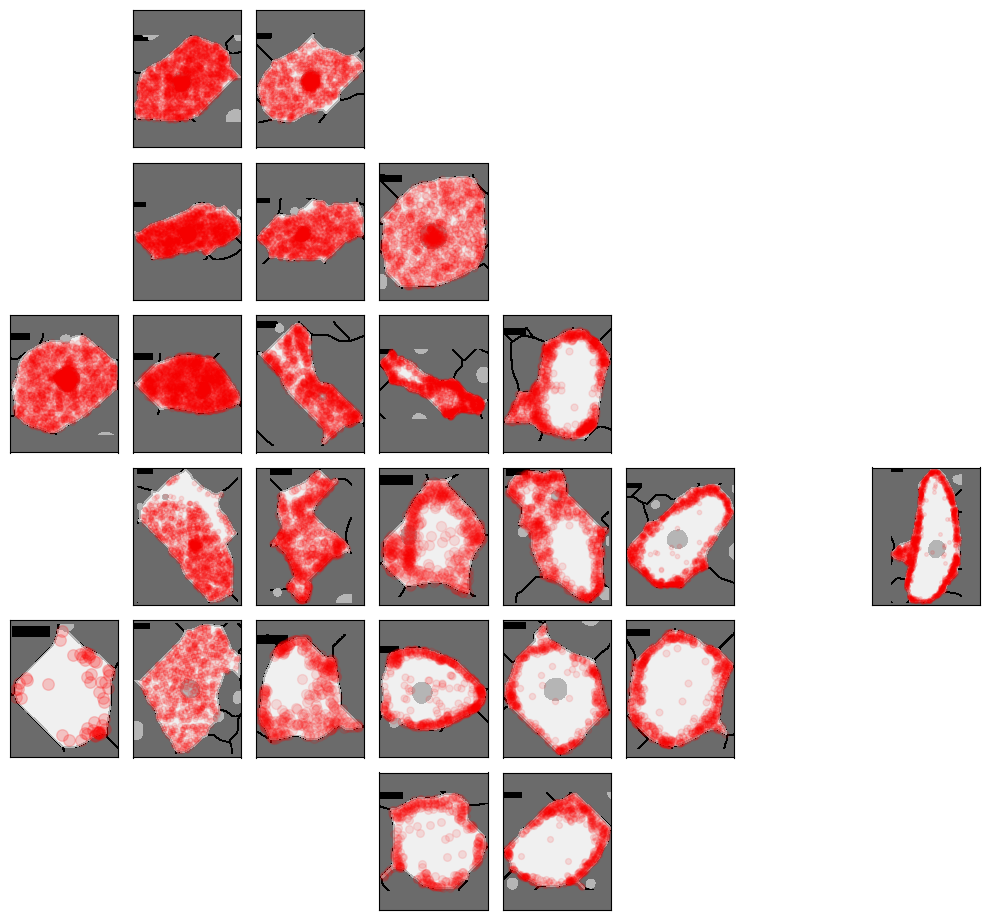

In [37]:
filename = dsrc + bname + pname + '_cell_sample'
fig, ax = plt.subplots( nrow, ncol, figsize=(10, 1.55*nrow), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel();

for i, j in enumerate(np.nonzero(minmask)[0]):
    ax[j].imshow(hcells[i]+1, cmap=cellular_cmap, origin='lower', extent=hextent[i], vmin=0, vmax=nnuc+2);
    ax[j].scatter(*hcoords[i][:2], color='r', marker='o', alpha=max([ alphaNmin, min([1, alphaNmax/len(hcoords[i][0])])]), s=int(4e6/hcells[i].size))
    ax[j].set_facecolor(wong[2])
    ax[j].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

foo = np.nonzero(~minmask)[0]
if len(foo) > 0:
    for j in foo:
        fig.delaxes(ax[j])

for a in ax.ravel():
    a.set_aspect('equal','datalim')
    
fig.tight_layout();
print(filename)
plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

../infected_focus_summer24/D2/G2_sublevel_both_step3_bw30/scale16_-_PI_1_1_1_H1+2_kde_sample


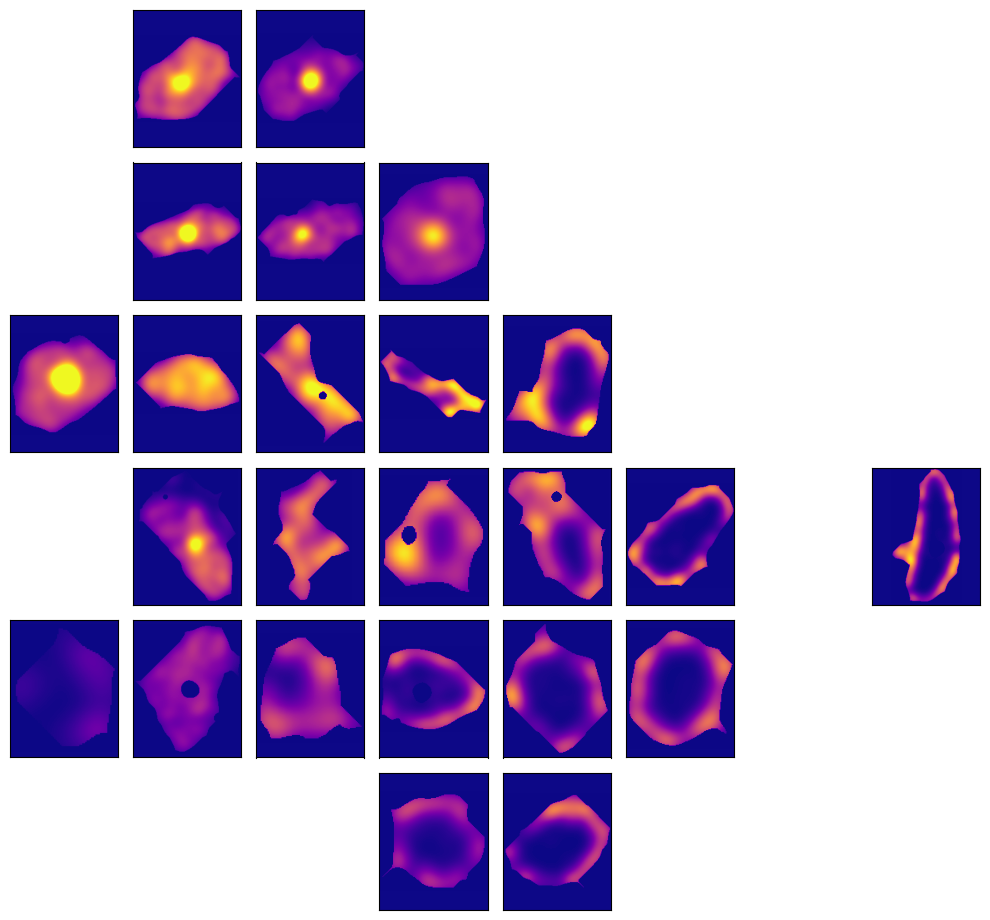

In [38]:
filename = dsrc + bname + pname + '_kde_sample'
        
fig, ax = plt.subplots( nrow, ncol, figsize=(10, 1.55*nrow), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel();

for i, j in enumerate(np.nonzero(minmask)[0]):
    ax[j].imshow(hkdes[i][hzlevel[i],:,:], origin='lower', cmap=Cmap, vmin=0, vmax=kmax, zorder=1)
    ax[j].set_facecolor( mpl.colormaps[Cmap](0) )
    ax[j].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

foo = np.nonzero(~minmask)[0]
if len(foo) > 0:
    for j in foo:
        fig.delaxes(ax[j])

for a in ax.ravel():
    a.set_aspect('equal','datalim')
    
fig.tight_layout();
print(filename)
plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

# How do PCs compare to transcriptomic density and number?

In [7]:
cyto_area = metacell.loc[Cells, 'cyto_area']
tnum = transcell.loc[transcriptomes[Genes], Cells.astype(str)]
density = 1000*tnum.values/cyto_area.values
density = np.hstack(density)

ztnum = stats.zscore(tnum.values, axis=None)
zdensity = stats.zscore(density, axis=None)
zpca = stats.zscore(pca, axis=0)

In [8]:
N = 50
H, xed, yed = [ [None for _ in range(pca.shape[1]) ] for _ in range(3)]
for i in range(len(H)):
    H[i], xed[i], yed[i] = np.histogram2d(density, pca[:,i], bins=[N,N])
    print(xed[i][1]-xed[i][0], yed[i][1]-yed[i][0])

0.38641548829057526 0.12902422000000002
0.38641548829057526 0.10270116399999996


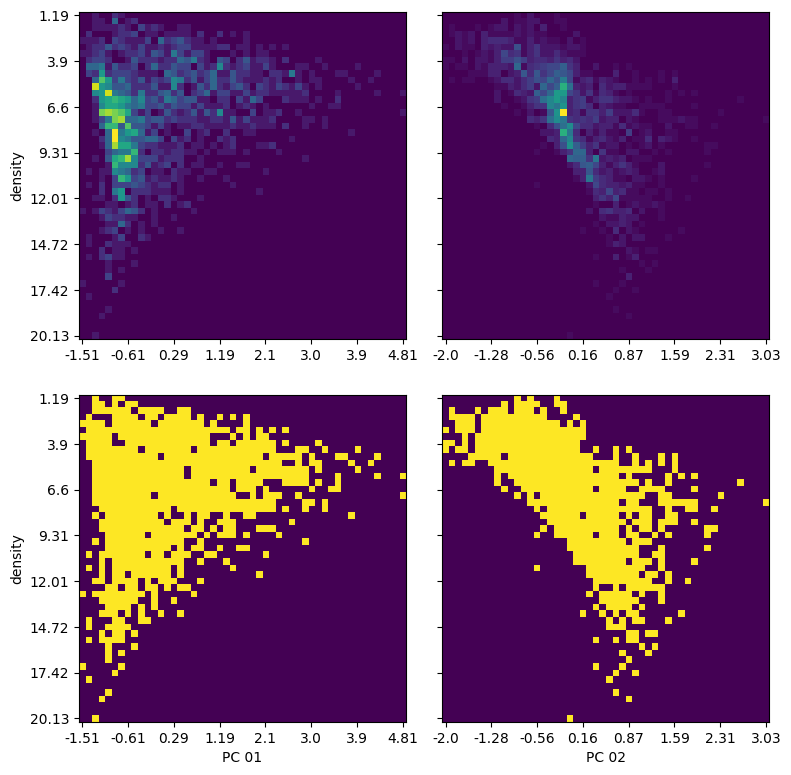

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8), sharex=False, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

for i in range(len(H)):
    ax[i].imshow(H[i])
    ax[i+len(H)].imshow(H[i] > 0)
    for j in range(2):
        ax[2*j+i].set_xticks(np.arange(0,N,int(np.sqrt(N))), np.round(yed[i][np.arange(0,N,int(np.sqrt(N)))],2));
        ax[2*j+i].set_yticks(np.arange(0,N,int(np.sqrt(N))), np.round(xed[i][np.arange(0,N,int(np.sqrt(N)))],2));
    ax[2+i].set_xlabel('PC {:02d}'.format(i+1))
    ax[2*i].set_ylabel('density')
    
fig.tight_layout()

In [121]:
pcnum = 1
ptp = np.zeros(len(xed[pcnum])-1)
for rho in range(len(ptp)):
    mask = (density >= xed[pcnum][rho]) & (density < xed[pcnum][rho+1])
    if np.sum(mask) > 0:
        ptp[rho] = np.ptp(pca[mask, pcnum])

print(np.argsort(ptp)[::-1])

rho = 13
mask = (density >= xed[pcnum][rho]) & (density < xed[pcnum][rho+1])

df = embedding.copy()
df['density'] = density
df = df.iloc[mask, [0,1] + [pcnum+2] + [-1]]
print(df.shape)
df.sort_values(by=df.columns[2])

[13 16 10 15  9 12 14 11 17  8 20 21 19  5 18 23  7  4 26  3 25  6  2 33
 28 24 22 27 30 29 34  1 31 32 37  0 39 36 41 42 35 38 40 44 46 45 43 48
 49 47]
(115, 4)


gene_ID  ndimage_ID  PCA02 (21.26)   density
1691       26        1956      -1.098891  6.471331
1662       26        1886      -1.089552  6.484016
1310       26        1114      -0.803936  6.233538
531        85        1383      -0.747538  6.369733
1567       26        1653      -0.717972  6.490260
...       ...         ...            ...       ...
1375       26        1246       0.910158  6.257700
1017       26         502       0.997481  6.588569
1784       26        2279       1.250358  6.585613
1542       26        1600       1.494118  6.332098
1725       26        2064       2.680231  6.385335

[115 rows x 4 columns]

In [122]:
linspace,delta = np.linspace(df.iloc[:,2].min(), df.iloc[:,2].max(), 10, retstep=True)
delta *= .5
reps = []
for i in range(len(linspace)):
    foo = np.abs(linspace[i] - df.iloc[:,2])
    bar = df.loc[(df['gene_ID'] == 85).values & (foo < delta).values]
    if len(bar) > 0:
        baz = np.abs(linspace[i] - bar.iloc[:,2])
        reps.append(baz[baz == baz.min()].index[0])
    else:
        bar = foo.min()
        if bar < delta:
            reps.append(df.loc[foo == bar].index[0])

reps = np.asarray(reps)
print(len(reps))
df.loc[reps]

8


gene_ID  ndimage_ID  PCA02 (21.26)   density
1691       26        1956      -1.098891  6.471331
755        85        1913      -0.645442  6.414993
687        85        1753      -0.268424  6.582863
740        85        1878       0.075519  6.562506
848        85        2226       0.520441  6.474935
1017       26         502       0.997481  6.588569
1542       26        1600       1.494118  6.332098
1725       26        2064       2.680231  6.385335

In [123]:
KDE, hcells, hcoords, hextent, hzhist = [ [None for _ in range(len(reps))] for _ in range(5) ]

for i in range(len(KDE)):
    cidx = embedding.loc[reps[i], 'ndimage_ID']
    cmask = label[ translocs[ embedding.loc[reps[i], 'gene_ID']]['Y'], translocs[embedding.loc[reps[i], 'gene_ID']]['X'] ] == cidx
    hcoords[i] = translocs[embedding.loc[reps[i], 'gene_ID']].iloc[cmask].values.T
    hzhist[i], _ = np.histogram(hcoords[i][2], bins=zbins, density=True)

    hcells[i], hextent[i] = utils.get_cell_img(cidx, metacell, label, lnuc, nnuc, pxbar=False)
    
    axes, grid, kdegmask, cgrid, outside_walls = utils.cell_grid_preparation(cidx, hcells[i], hextent[i], zmax, stepsize, cell_nuc)
    
    kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(hcoords[i].T).evaluate(grid)
    kde = kde[kdegmask]/(np.sum(kde[kdegmask])*(stepsize**len(hcoords[i])))
    kde[outside_walls] = 0
    kde = kde/(np.sum(kde)*(stepsize**len(hcoords[i])))
    
    KDE[i] = kde.reshape( list(map(len, axes))[::-1], order='F')
    if i%10 == 0:
        print(i)

for cell in hcells:
    cell[pxbar] = -1

hkdes = [ KDE[i].copy() * ratios[invGenes[embedding.loc[reps[i], 'gene_ID']]][ invCells[embedding.loc[reps[i], 'ndimage_ID']] ] for i in range(len(KDE))]
for i in range(len(KDE)):
    hkdes[i][hkdes[i] == 0] = -kmax*1e-2
hzlevel = np.array(list(map(np.argmax, hzhist)))

0


../infected_focus_summer24/D2/G2_sublevel_both_step3_bw25/scale32_-_PI_1_1_1_H1+2_density13_pc02


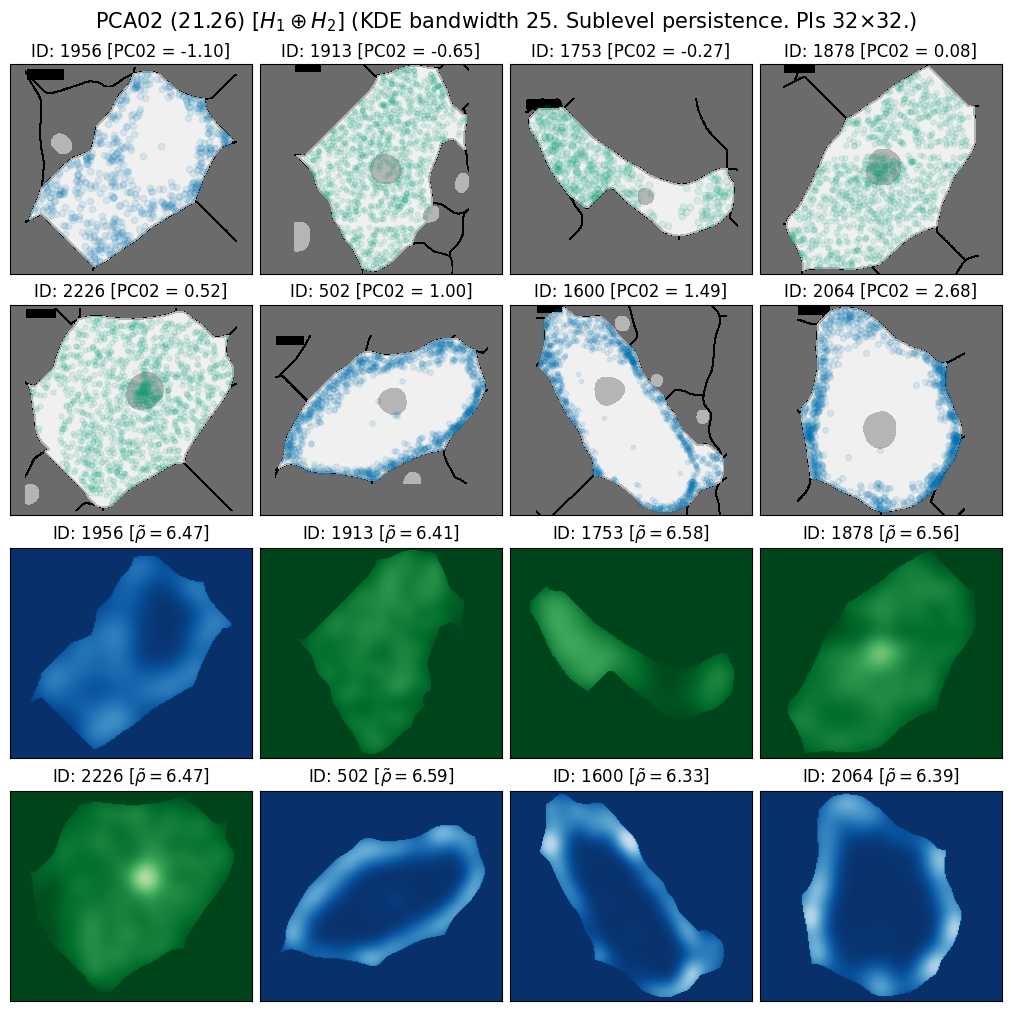

In [124]:
fig,ax = plt.subplots(4, 4, figsize=(10,10), layout="constrained")
ax = np.atleast_1d(ax).ravel()

fig.suptitle(embedding.columns[2+pcnum]+Pname+' ('+Bname+')', fontsize=1.25*fs)

for i in range(len(reps)):
    j = i
    ax[j].imshow(hcells[i]+1, cmap=cellular_cmap, origin='lower', extent=hextent[i], vmin=0, vmax=nnuc+2);
    ax[j].scatter(hcoords[i][0], hcoords[i][1], color=color[df.loc[reps[i], 'gene_ID']%len(color)], marker='o', s=int(4e6/hcells[i].size),
                       alpha=max([0.1, min([1, 25/len(hcoords[i][0])])]))
    ax[j].set_facecolor(wong[2])
    ax[j].set_title('ID: {} [PC{:02d} = {:.2f}]'.format(df.loc[reps[i], 'ndimage_ID'], pcnum+1, df.loc[reps[i], df.columns[2]]), fontsize=fs)
    
for i in range(len(reps)):
    j = i+8
    z = np.argmax(np.sum(hkdes[i], axis=(1,2)))
    #ax[j].imshow(hkdes[i][z,:,:], origin='lower', cmap=cmap[4*((i)//N)], vmin=0, vmax=kmax)
    ax[j].imshow(np.max(hkdes[i], axis=0), origin='lower', cmap=cmap[df.loc[reps[i], 'gene_ID']%len(cmap)], vmax=kmax)
    ax[j].set_facecolor( mpl.colormaps[ cmap[df.loc[reps[i], 'gene_ID']%len(cmap)] ](0) )
    ax[j].set_title('ID: {} '.format(df.loc[reps[i], 'ndimage_ID']) + '[$\\tilde{\\rho}=$' + '{:.2f}]'.format(df.loc[reps[i], 'density']), fontsize=fs)
    
for i in range(len(ax)):
    ax[i].set_aspect('equal', 'datalim')
    ax[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

filename = dsrc + bname + pname + '_density{:02d}_pc{:02d}'.format(rho, pcnum+1)
print(filename)
plt.savefig(filename, dpi=dpi, bbox_inches='tight', pil_kwargs={'optimize':True})

# Explore a PCA continuum

In [126]:
transcriptomes[Genes]

array(['GLYMA_17G195900', 'GLYMA_05G092200'], dtype='<U15')

In [59]:
gidx = 0
pmask = embedding['gene_ID'] == Genes[gidx]

cellloc = metacell.loc[ embedding.loc[pmask, 'ndimage_ID'], ['ndimage_comX','ndimage_comY','orig_cellID'] ].values
ecc = metaecc.loc[embedding.loc[pmask, 'ndimage_ID'], 'eccentricity'].values
ecc = metaecc['eccentricity'].max() - ecc

../infected_focus_summer24/D2/G2_sublevel_both_step3_bw25/scale24_-_PI_1_1_1_H1+2_GLYMA_17G195900


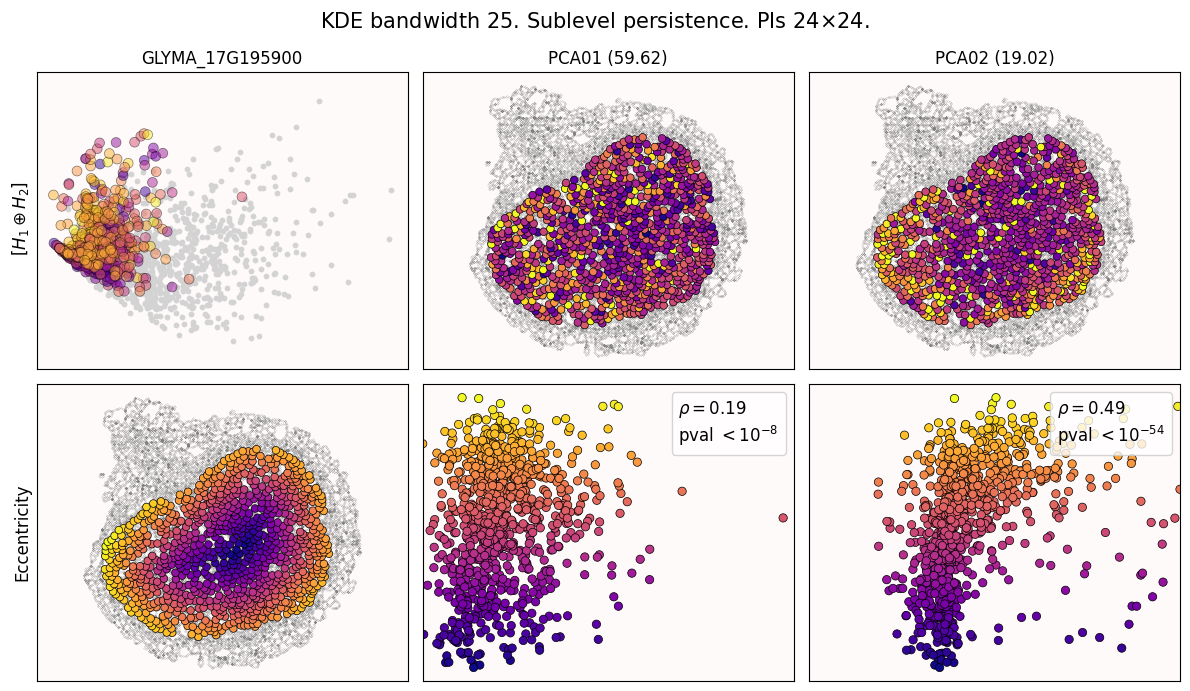

In [60]:
fig, ax = plt.subplots(2, 1+pca.shape[1], figsize=(12,7), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].scatter(pca[~pmask,0], pca[~pmask,1], c='lightgray', marker='o', s=10, zorder=1)
ax[i].scatter(*(pca[pmask].T), c=ecc, marker='o', s=50, zorder=2, cmap=Cmap, edgecolor='k', linewidth=0.5, alpha=0.5)
ax[i].set_ylabel(Pname, fontsize=fs)

for i,c in zip( range(1, 2+pca.shape[1]) , np.vstack((pca[pmask,:].T,ecc)) ):
    vmax = utils.maximum_qq_size(c, alpha=0.25, iqr_factor=1.5)
    vmin = utils.minimum_qq_size(c, alpha=0.25, iqr_factor=1.5)

    ax[i].scatter(wc[1], wc[0], c='#808080', marker='.', s=0.1, zorder=1)
    ax[i].scatter(*cellloc.T[:2], c=c, marker='o', cmap=Cmap,
                  edgecolor='black', linewidth=0.5, zorder=2, s=30, vmax=vmax, vmin=vmin)

ax[1+pca.shape[1]].set_ylabel('Eccentricity', fontsize=fs)
k = 2+pca.shape[1]
for i in range(pca.shape[1]):
    corr = stats.spearmanr(ecc, pca[pmask, i])
    expo = int(np.ceil(np.log10(corr.pvalue)))
    ll = '$\\rho = ${:.2f}\npval $< 10^{{{}}}$'.format(corr.statistic, expo)
    ax[i+k].scatter(pca[pmask,i], ecc, c=ecc, cmap=Cmap, marker='o', edgecolor='black', linewidth=0.5, label=ll)
    ax[i+k].set_xlim(pca[pmask].min(), pca[pmask].max())
    ax[i+k].legend(fontsize=fs, handlelength=0, handletextpad=0, loc='upper right', markerscale=0)

for i in range(2+pca.shape[1]):
    ax[i].set_aspect('equal','datalim')
title = [transcriptomes[Genes[gidx]]] + list(embedding.columns[2:2+pca.shape[1]]) + ['' for _ in range(len(ax))]
for i in range(len(ax)):
    ax[i].set_title(title[i], fontsize=fs)
    ax[i].set_facecolor('snow')
    ax[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

fig.suptitle(Bname, fontsize=1.25*fs)
fig.tight_layout();
filename = dsrc + bname + pname + '_{}'.format(transcriptomes[Genes[gidx]])
print(filename)
#plt.savefig(filename, dpi=dpi, bbox_inches='tight', pil_kwargs={'optimize':True})

In [59]:
pcnum = 0
corr = stats.spearmanr(ecc, pca[pmask, pcnum]).statistic
arr = pca[pmask, pcnum] * np.sign(corr)
vmax = utils.maximum_qq_size(arr, alpha=0.25, iqr_factor=1.5)
vmin = utils.minimum_qq_size(arr, alpha=0.25, iqr_factor=1.5)

qq = 0.12
hqmask = arr > np.quantile(arr, 1-qq)
lqmask = arr < np.quantile(arr, qq)
print(np.sum(hqmask), np.sum(lqmask))

LQmask = np.intersect1d(np.nonzero(lqmask)[0], np.nonzero(ecc < np.quantile(ecc, qq))[0])
HQmask = np.intersect1d(np.nonzero(hqmask)[0], np.nonzero(ecc > np.quantile(ecc, 1-qq))[0])
print(len(LQmask))
print(len(HQmask))

111 111
44
10


In [60]:
N = 6
lq = rng.choice(LQmask, N, replace=False)
hq = rng.choice(HQmask, N, replace=False)

orig_idx = cellloc[np.hstack((lq,hq)), 2].astype(int)
cyto_area = metacell.loc[embedding.loc[pmask].iloc[np.hstack((lq,hq))]['ndimage_ID'], 'cyto_area']
tnum = transcell.loc[transcriptomes[Genes[gidx]], embedding.loc[pmask].iloc[np.hstack((lq,hq))]['ndimage_ID'].values.astype(str)]
density = 1000*tnum.values/cyto_area.values
reps = embedding.loc[pmask].iloc[np.hstack((lq,hq))].index.values

In [61]:
KDE, hcells, hcoords, hextent, hzhist = [ [None for _ in range(len(reps))] for _ in range(5) ]

for i in range(len(KDE)):
    cidx = embedding.loc[reps[i], 'ndimage_ID']
    cmask = label[ translocs[ embedding.loc[reps[i], 'gene_ID']]['Y'], translocs[embedding.loc[reps[i], 'gene_ID']]['X'] ] == cidx
    hcoords[i] = translocs[embedding.loc[reps[i], 'gene_ID']].iloc[cmask].values.T
    hzhist[i], _ = np.histogram(hcoords[i][2], bins=zbins, density=True)

    hcells[i], hextent[i] = utils.get_cell_img(cidx, metacell, label, lnuc, nnuc, pxbar=False)
    
    axes, grid, kdegmask, cgrid, outside_walls = utils.cell_grid_preparation(cidx, hcells[i], hextent[i], zmax, stepsize, cell_nuc)
       
    kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(hcoords[i].T).evaluate(grid)
    kde = kde[kdegmask]/(np.sum(kde[kdegmask])*(stepsize**len(hcoords[i])))
    kde[outside_walls] = 0
    kde = kde/(np.sum(kde)*(stepsize**len(hcoords[i])))
    
    KDE[i] = kde.reshape( list(map(len, axes))[::-1], order='F')
    if i%10 == 0:
        print(i)
    hcells[i][pxbar] = -1

hkdes = [ KDE[i].copy() * ratios[invGenes[embedding.loc[reps[i], 'gene_ID']]][ invCells[embedding.loc[reps[i], 'ndimage_ID']] ] for i in range(len(KDE))]
hzlevel = np.array(list(map(np.argmax, hzhist)))

0
10


../infected_focus_summer24/D2/G2_sublevel_both_step3_bw15/scale40_-_PI_1_1_1_H1+2_kde_pc01_GLYMA_05G092200


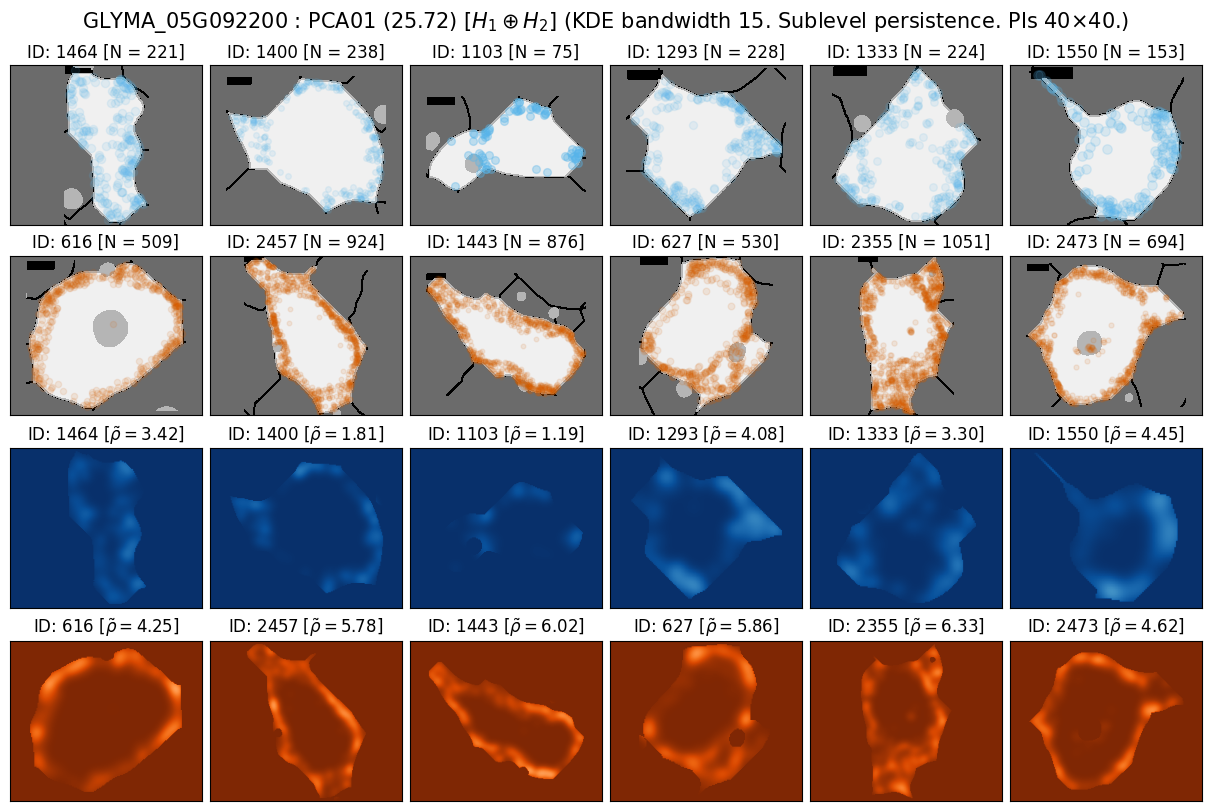

In [62]:
fig,ax = plt.subplots(4, N, figsize=(2*N,8), layout="constrained")
ax = np.atleast_1d(ax).ravel()

fig.suptitle(transcriptomes[Genes[gidx]]+' : '+embedding.columns[2+pcnum]+Pname+' ('+Bname+')', fontsize=1.25*fs)

for i in range(2*N):
    j = i
    ax[j].imshow(hcells[i]+1, cmap=cellular_cmap, origin='lower', extent=hextent[i], vmin=0, vmax=nnuc+2);
    ax[j].scatter(hcoords[i][0], hcoords[i][1], color=color[4*((i)//N)], marker='o', s=int(4e6/hcells[i].size),
                       alpha=max([0.1, min([1, 25/len(hcoords[i][0])])]))
    ax[j].set_facecolor(wong[2])
    ax[j].set_title('ID: {} [N = {}]'.format(orig_idx[i], len(hcoords[i][0])), fontsize=fs)
    
for i in range(2*N):
    j = i+2*N
    ax[j].imshow(hkdes[i][hzlevel[i],:,:], origin='lower', cmap=cmap[4*((i)//N)], vmin=0, vmax=kmax)
    ax[j].set_facecolor( mpl.colormaps[ cmap[4*((i)//N)] ](0) )
    ax[j].set_title('ID: {} '.format(orig_idx[i]) + '[$\\tilde{\\rho}=$' + '{:.2f}]'.format(density[i]), fontsize=fs)
    
for i in range(len(ax)):
    ax[i].set_aspect('equal', 'datalim')
    ax[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

filename = dsrc + bname + pname + '_kde_pc{:02d}_{}'.format(pcnum+1, transcriptomes[Genes[gidx]])
print(filename)
plt.savefig(filename, dpi=dpi, bbox_inches='tight', pil_kwargs={'optimize':True})

# PCA differences

In [42]:
gi, gj = 0,1
merge = embedding[embedding['gene_ID'] == Genes[gi]].merge(embedding[embedding['gene_ID'] == Genes[gj]], how='inner',
                                                           on = 'ndimage_ID', suffixes=['_{}'.format(i) for i in [gi,gj]])
merge = merge.drop(columns=['gene_ID_{}'.format(i) for i in [gi,gj]])

../infected_focus_summer24/D2/G2_sublevel_both_step3_bw30/scale16_-_PI_1_1_1_H1+2_GLYMA_17G195900_pc_vs_pc_GLYMA_05G092200


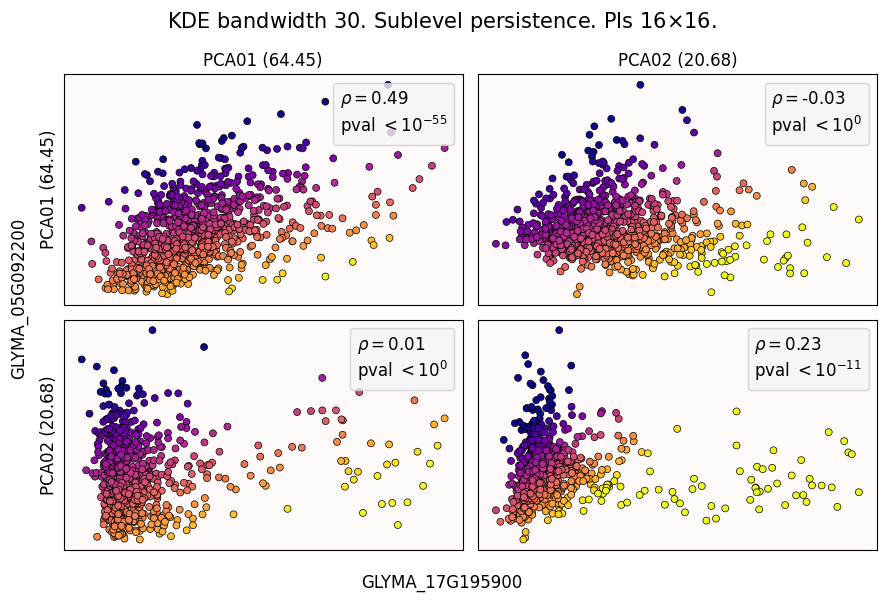

In [35]:
fig, ax = plt.subplots(2,2, figsize=(9,6), sharex=False, sharey=False)

for i in range(2):
    ax[i,0].set_ylabel(embedding.columns[2+i], fontsize=fs)
    ax[0,i].set_title(embedding.columns[2+i], fontsize=fs)

for it in itertools.product(range(2), repeat=2):
    
    pca_comp = merge.loc[:, [ embedding.columns[2 + it[i]]+'_{}'.format(i) for i in range(2)] ]
    diff = np.subtract(*(pca_comp.T.values))
    vmin = utils.minimum_qq_size( diff, alpha=0.25, iqr_factor=1.5)
    vmax = utils.maximum_qq_size( diff, alpha=0.25, iqr_factor=1.5)
    corr = stats.spearmanr(*(pca_comp.T.values))
    expo = int(np.ceil(np.log10(corr.pvalue)))
    
    ll = '$\\rho = ${:.2f}\npval $< 10^{{{}}}$'.format(corr.statistic, expo)
        
    ax[it].scatter(pca_comp.iloc[:,0], pca_comp.iloc[:,1], c=diff, marker='o', cmap='plasma',
                     edgecolor='black', linewidth=0.5, zorder=2, s=25, vmin=vmin, vmax=vmax, label=ll)
    ax[it].legend(fontsize=fs, handlelength=0, handletextpad=0, loc='upper right', markerscale=0, facecolor='whitesmoke')

for a in ax.ravel():
    a.set_facecolor('snow')
    a.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

fig.supxlabel(transcriptomes[Genes[gi]], fontsize=fs)
fig.supylabel(transcriptomes[Genes[gj]], fontsize=fs)
fig.suptitle(Bname, fontsize=1.25*fs)
fig.tight_layout();
filename = dsrc + bname + pname + '_{}_pc_vs_pc_{}'.format(*transcriptomes[Genes[[gi,gj]]])
print(filename)
#plt.savefig(filename, dpi=dpi, bbox_inches='tight', pil_kwargs={'optimize':True})

In [44]:
ord_comparison = [1,2,np.inf]
pca_comparison = [ [0], [1], [0,1] ]
merge = embedding[embedding['gene_ID'] == Genes[gi]].merge(embedding[embedding['gene_ID'] == Genes[gj]], how='inner',
                                                           on = 'ndimage_ID', suffixes=['_{}'.format(i) for i in [gi,gj]])
imi = [embedding[(embedding['ndimage_ID'] == i) & (embedding['gene_ID'] == Genes[gi])].index[0] for i in merge['ndimage_ID'] ]
imj = [embedding[(embedding['ndimage_ID'] == i) & (embedding['gene_ID'] == Genes[gj])].index[0] for i in merge['ndimage_ID'] ]
dimg = np.abs(full_img[hdims][:, imi] - full_img[hdims][:, imj])
dimg = dimg.reshape(dimg.shape[0],dimg.shape[1],dimg.shape[2]*dimg.shape[3])

diff_option = [[ [embedding.columns[2+i]+'_{}'.format(x) for i in perm ] for x in [gi,gj] ] for perm in pca_comparison]
title = ['$\\Delta$ ' + '$\\oplus$'.join(['PC{}'.format(x+1) for x in perm ])  for perm in pca_comparison]
title += ['$L_{{{}}}(\\Delta$ PI)'.format(ord).replace('inf','\\infty') for ord in ord_comparison] 

ftitle = ['+'.join(['{}'.format(x+1) for x in perm ])  for perm in pca_comparison]
ftitle += ['L{}'.format(ord) for ord in ord_comparison] 

diffs_pc = np.array([ np.linalg.norm(merge.loc[:, diff_option[i][0]].values - merge.loc[:, diff_option[i][1]].values, ord=2, axis=1) for i in range(len(diff_option))])
diffs_pi = np.array([ np.max(np.linalg.norm( dimg, ord=ord, axis=2), axis=0) for ord in ord_comparison ])
diffs = np.vstack((diffs_pc, diffs_pi))


../infected_focus_summer24/D2/G2_sublevel_both_step3_bw25/scale24_-_PI_1_1_1_H1+2_GLYMA_17G195900_vs_GLYMA_05G092200


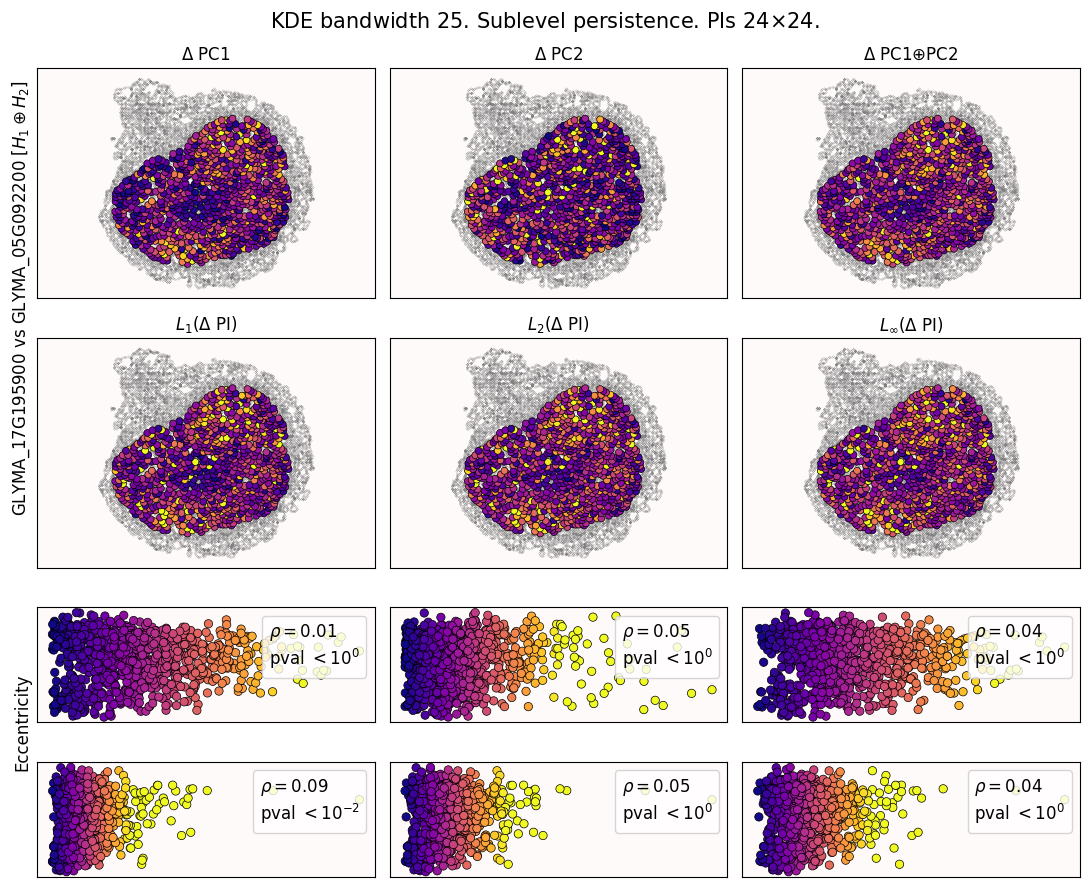

In [45]:
fig, ax = plt.subplots(4, len(diff_option), figsize=(11,9), sharex=False, sharey=False, height_ratios=[2,2,1,1])
ax[0,0].set_ylabel('{} vs {}'.format(*transcriptomes[Genes[[gi,gj]]]) + Pname, fontsize=fs, y=0)
ax[2,0].set_ylabel('Eccentricity', fontsize=fs, y=0)

for i in range(len(diffs)):
    j = ((i//ax.shape[1]), i%ax.shape[1])
    k = ((i//ax.shape[1])+2, i%ax.shape[1])
    ax[j].set_title(title[i], fontsize=fs)
    diff = diffs[i]
    vmin = utils.minimum_qq_size( diff, alpha=0.25, iqr_factor=1.5)
    vmax = utils.maximum_qq_size( diff, alpha=0.25, iqr_factor=1.5)
    
    ax[j].scatter(wc[1], wc[0], c='#808080', marker='.', s=0.1, zorder=1)
    ax[j].scatter(cellloc[:,0], cellloc[:,1], c=diff, marker='o', cmap='plasma',
                     edgecolor='black', linewidth=0.5, zorder=2, s=25, vmin=vmin, vmax=vmax)
    ax[j].set_aspect('equal', 'datalim')

    corr = stats.spearmanr(ecc, diff)
    expo = int(np.ceil(np.log10(corr.pvalue)))
    ll = '$\\rho = ${:.2f}\npval $< 10^{{{}}}$'.format(corr.statistic, expo)
    ax[k].scatter(diff, ecc, c=diff, cmap=Cmap, marker='o', edgecolor='black', linewidth=0.5, vmin=vmin, vmax=vmax, label=ll)
    ax[k].legend(fontsize=fs, handlelength=0, handletextpad=0, loc='upper right', markerscale=0)

for a in ax.ravel():
    a.set_facecolor('snow')
    a.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
fig.suptitle(Bname, fontsize=1.25*fs)
fig.tight_layout();
filename = dsrc + bname + pname + '_{}_vs_{}'.format(*transcriptomes[Genes[[gi,gj]]])
print(filename)

# Visualize those differences

In [38]:
dixd = 2
diff = diffs[dixd]
vmin = utils.minimum_qq_size( diff, alpha=0.25, iqr_factor=1.5)
vmax = utils.maximum_qq_size( diff, alpha=0.25, iqr_factor=1.5)

argsort = np.argsort(diff)
ncol = 6

reps = merge.iloc[np.hstack( (argsort[:ncol], argsort[-ncol:]))]['ndimage_ID'].values
cgi = [embedding[(embedding['ndimage_ID'] == reps[i]) & (embedding['gene_ID'] == Genes[gi])].index[0] for i in range(len(reps))]
cgj = [embedding[(embedding['ndimage_ID'] == reps[i]) & (embedding['gene_ID'] == Genes[gj])].index[0] for i in range(len(reps))]
reps = cgi[:ncol] + cgj[:ncol] + cgi[-ncol:] + cgj[-ncol:]

cyto_area = metacell.loc[ embedding.loc[reps]['ndimage_ID'], 'cyto_area']
tnum = transcell.loc[ transcriptomes[Genes[[gi,gj]]], embedding.loc[cgi[:ncol]]['ndimage_ID'].values.astype(str)].values.ravel()
tnum = np.hstack((tnum,transcell.loc[transcriptomes[Genes[[gi,gj]]],embedding.loc[cgi[-ncol:]]['ndimage_ID'].values.astype(str)].values.ravel()))
density = 1000*tnum/cyto_area.values

In [40]:
KDE, hcells, hcoords, hextent, hzhist = [ [None for _ in range(len(reps))] for _ in range(5) ]

for i in range(len(KDE)):
    cidx = embedding.loc[reps[i], 'ndimage_ID']
    cmask = label[ translocs[ embedding.loc[reps[i], 'gene_ID']]['Y'], translocs[embedding.loc[reps[i], 'gene_ID']]['X'] ] == cidx
    hcoords[i] = translocs[embedding.loc[reps[i], 'gene_ID']].iloc[cmask].values.T
    hzhist[i], _ = np.histogram(hcoords[i][2], bins=zbins, density=True)

    hcells[i], hextent[i] = utils.get_cell_img(cidx, metacell, label, lnuc, nnuc, pxbar=False)
    
    axes, grid, kdegmask, cgrid, outside_walls = utils.cell_grid_preparation(cidx, hcells[i], hextent[i], zmax, stepsize, cell_nuc)
       
    kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(hcoords[i].T).evaluate(grid)
    kde = kde[kdegmask]/(np.sum(kde[kdegmask])*(stepsize**len(hcoords[i])))
    kde[outside_walls] = 0
    kde = kde/(np.sum(kde)*(stepsize**len(hcoords[i])))
    
    KDE[i] = kde.reshape( list(map(len, axes))[::-1], order='F')
    if i%10 == 0:
        print(i)

for cell in hcells:
    cell[pxbar] = -1

hkdes = [ KDE[i].copy() * ratios[invGenes[embedding.loc[reps[i], 'gene_ID']]][ invCells[embedding.loc[reps[i], 'ndimage_ID']] ] for i in range(len(KDE))]
hzlevel = np.array(list(map(np.argmax, hzhist)))

0
10
20


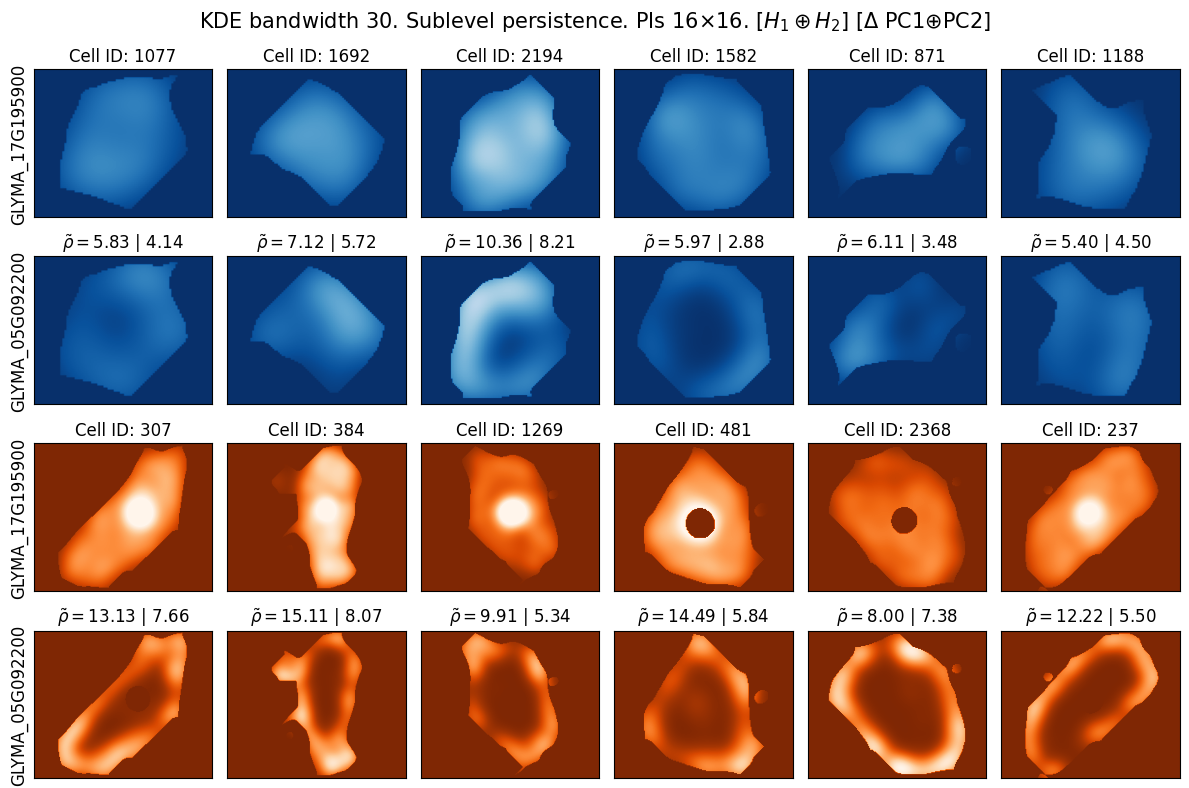

In [41]:
fig, ax = plt.subplots( len(reps)//ncol, ncol, figsize=(12, 8), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel();

for i in range(len(KDE)):
    ax[i].imshow(hkdes[i][hzlevel[i],:,:], origin='lower', cmap=cmap[4*(i//(2*ncol))], vmin=0, vmax=kmax, zorder=1)
    ax[i].set_facecolor( mpl.colormaps[ cmap[4*((i)//(2*ncol))] ](0) )
    ax[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    
for kstart, kend in [(0, ncol), (2*ncol, 3*ncol)]:
    for i in range(kstart, kend):
        ax[i].set_title('Cell ID: {}'.format(metacell.loc[embedding.loc[reps[i], 'ndimage_ID'], 'orig_cellID']), fontsize=fs)
        ax[i+ncol].set_title('$\\tilde{\\rho}=$'+'{:.2f} | {:.2f}'.format(*density[[i,ncol+i]]), fontsize=fs)
        
for i in [0,2]:
    ax[ncol*i].set_ylabel(transcriptomes[Genes[gi]], fontsize=12)
for i in [1,3]:
    ax[ncol*i].set_ylabel(transcriptomes[Genes[gj]], fontsize=12)

for a in ax.ravel():
    a.set_aspect('equal','datalim')

fig.suptitle(Bname + Pname + ' ['+title[dixd]+']', fontsize=1.25*fs)
fig.tight_layout();
filename = dsrc + bname + pname + '_{}_kde_{}_vs_{}'.format(ftitle[dixd], *transcriptomes[Genes[[gi,gj]]])
#plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

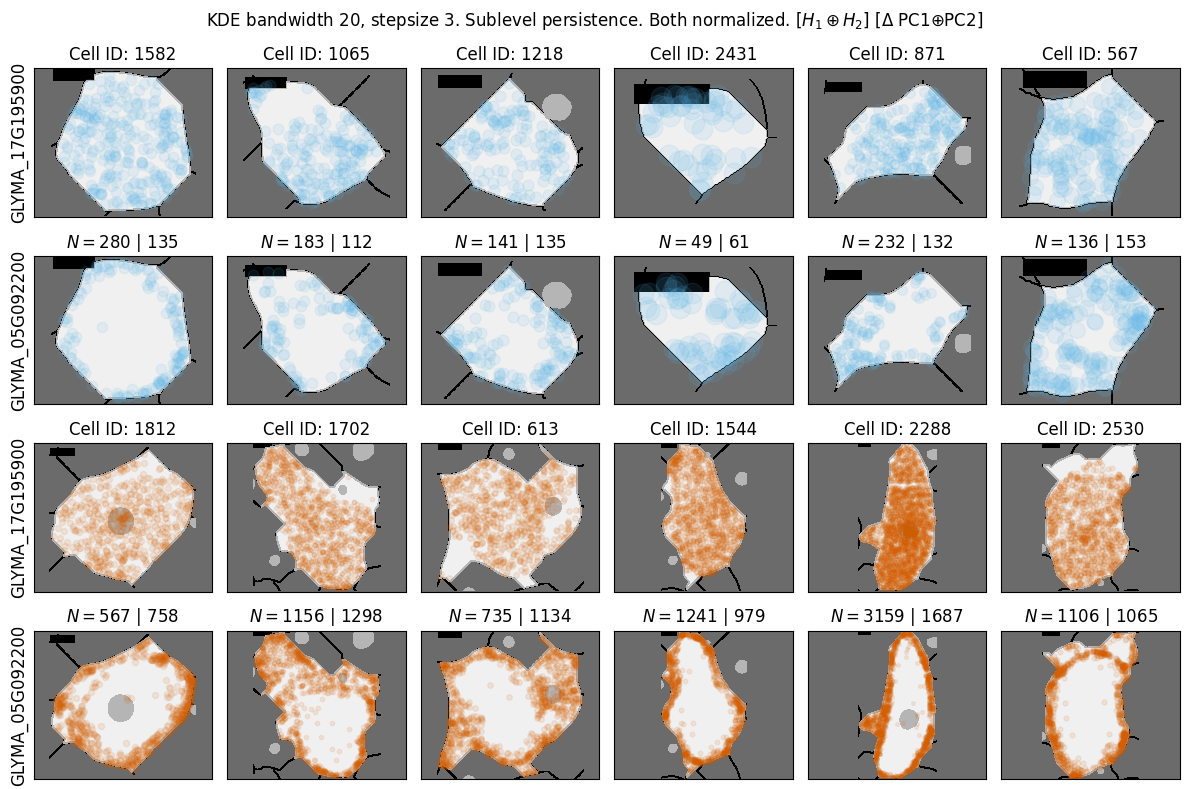

In [169]:
fig, ax = plt.subplots( len(reps)//ncol, ncol, figsize=(12, 8), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel();

for i in range(len(hcells)):
    fig.axes[i].imshow(hcells[i]+1, cmap=cellular_cmap, origin='lower', extent=hextent[i], vmin=0, vmax=nnuc+2);
    fig.axes[i].scatter(*hcoords[i][:2], color=color[4*(i//(2*ncol))], marker='o', alpha=0.1, s=int(4e6/hcells[i].size))
    fig.axes[i].set_facecolor(wong[2])
    ax[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    
for kstart, kend in [(0, ncol), (2*ncol, 3*ncol)]:
    for i in range(kstart, kend):
        ax[i].set_title('Cell ID: {}'.format(metacell.loc[embedding.loc[reps[i], 'ndimage_ID'], 'orig_cellID']), fontsize=fs)
        ax[i+ncol].set_title('$N=$'+'{} | {}'.format(len(hcoords[i][0]), len(hcoords[ncol+i][0])), fontsize=fs)
        
for i in [0,2]:
    ax[ncol*i].set_ylabel(transcriptomes[Genes[gi]], fontsize=12)
for i in [1,3]:
    ax[ncol*i].set_ylabel(transcriptomes[Genes[gj]], fontsize=12)

for a in ax.ravel():
    a.set_aspect('equal','datalim')

fig.suptitle(Bname[:68] + Pname + ' ['+title[dixd]+']', fontsize=fs)
fig.tight_layout();
filename = dsrc + bname + pname + '_{}_cell_{}_vs_{}'.format(ftitle[dixd], *transcriptomes[Genes[[gi,gj]]])
#plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

# Comparing infected cells based on 05GLYMA_05G203100 

In [46]:
gi, gj = 0,1
pvaltol = 1e-2
id_gene = 'GLYMA_05G203100'
full_id_gene = ''.join(id_gene)
id_gene = id_gene[-9:]
o5glabels = ['All', 'w/ '+id_gene, 'w/o '+id_gene]

fivegcolumns = []
for j in [gi, gj]:
    for k in range(2):
        for t in ['KS', 'MW', 'Anderson']:
            foo = 'w_vs_wo_{}_-_PC{}_-_{}_-_{}_pval'.format(id_gene[-9:], k+1, transcriptomes[Genes[j]][-9:], t)
            fivegcolumns.append(foo)

for w in ['all', 'w_'+id_gene,'wo_'+id_gene]:
    for it in itertools.product(range(2), repeat=2):
        for t in ['rho', 'pval']:
            foo = '{}_-_{}_PC{}_-_vs_-_{}_PC{}_-_spearman_{}'.format(w, transcriptomes[Genes[gi]][-9:], it[0]+1, transcriptomes[Genes[gj]][-9:], it[1]+1, t)
            fivegcolumns.append(foo)

for w in ['all', 'w_'+id_gene,'wo_'+id_gene]:
    for j, gidx in enumerate([gi,gj]):
        for k in range(2):
            for t in ['rho', 'pval']:
                foo = '{}_-_ecc_-_vs_-_{}_PC{}_-_spearman_{}'.format(w, transcriptomes[Genes[gidx]][-9:], k+1, t)
                fivegcolumns.append(foo)

In [61]:
merge = embedding[embedding['gene_ID'] == Genes[gi]]
merge = merge.merge(embedding[embedding['gene_ID'] == Genes[gj]],how='inner', on = 'ndimage_ID', suffixes=['_{}'.format(i) for i in [gi,gj]])
merge = merge.drop(columns=['gene_ID_{}'.format(i) for i in [gi,gj]])

cellloc = metacell.loc[ merge['ndimage_ID'].values, ['ndimage_comX','ndimage_comY','orig_cellID'] ].values

ecc = metaecc.loc[merge['ndimage_ID'].values, 'eccentricity'].values
ecc = metaecc['eccentricity'].max() - ecc

filename = dsrc + bname + pname + '_{}_{}_pca_{}.csv'.format(*transcriptomes[Genes[[gi,gj]]], full_id_gene)
print(filename)
if not os.path.isfile(filename):

    fivegdata = np.zeros( (10, len(fivegcolumns) ))
    
    for i in range(len(fivegdata)):
        ct = 0
        min5G = i
        O5G = (transcell.loc[full_id_gene, Cells.astype(str)] > min5G).values
        nonO5G = (transcell.loc[full_id_gene, Cells.astype(str)] <= min5G).values
        for j in [gi, gj]:
            foo = [ embedding[embedding['gene_ID'] == Genes[j]].iloc[mask, 2:4].values for mask in [O5G, nonO5G] ]
            for k in range(2):
                bar = [ x[:,k] for x in foo ]
                test0 = stats.ks_2samp(*bar)
                test1 = stats.mannwhitneyu(*bar)
                test2 = stats.anderson_ksamp(bar, method=permmethod)
                fivegdata[i, ct:ct+3] = [test0.pvalue, test1.pvalue, test2.pvalue]
                ct += 3
        
        for j,mask in enumerate([np.ones(len(merge),dtype=bool), O5G, nonO5G]):
            for it in itertools.product(range(2), repeat=2):
                
                pca_comp = merge.loc[mask, [ embedding.columns[2 + it[x]]+'_{}'.format(x) for x in range(2)] ]
                corr = stats.spearmanr(*(pca_comp.T.values))
                fivegdata[i, ct:ct+2] = [corr.statistic, corr.pvalue]
                ct += 2
    
        for j,mask in enumerate([np.ones(len(merge),dtype=bool), O5G, nonO5G]):
            for gidx in [gi,gj]:
                pmask = embedding['gene_ID'] == Genes[gidx]
                
                for k in range(2):
                    corr = stats.spearmanr(ecc[mask], pca[pmask, k][mask])
                    fivegdata[i, ct:ct+2] = [corr.statistic, corr.pvalue]
                    ct += 2
    fivegdata = pd.DataFrame(fivegdata, columns=fivegcolumns).to_csv(filename, index=False, header=False)

fivegdata = pd.read_csv(filename, header=None, names=fivegcolumns)
fivegdata.head()

../infected_focus_summer24/D2/G2_sublevel_both_step3_bw25/scale24_-_PI_1_1_1_H1+2_GLYMA_17G195900_GLYMA_05G092200_pca_GLYMA_05G203100.csv


w_vs_wo_05G203100_-_PC1_-_17G195900_-_KS_pval  \
0                                       0.002332   
1                                       0.000460   
2                                       0.008027   
3                                       0.146953   
4                                       0.418529   

   w_vs_wo_05G203100_-_PC1_-_17G195900_-_MW_pval  \
0                                       0.002247   
1                                       0.000215   
2                                       0.020616   
3                                       0.218089   
4                                       0.805840   

   w_vs_wo_05G203100_-_PC1_-_17G195900_-_Anderson_pval  \
0                                              0.002     
1                                              0.001     
2                                              0.017     
3                                              0.114     
4                                              0.205     

   w_vs_wo_05G203100_-_PC2_-_17G195900_-_KS_pval  \
0                                       0.003111   
1                                       0.006805   
2                                       0.211305   
3                                       0.484191   
4                                       0.151296   

   w_vs_wo_05G203100_-_PC2_-_17G195900_-_MW_pval  \
0                                       0.089803   
1                                       0.053187   
2                                       0.208530   
3                                       0.171087   
4                                       0.039584   

   w_vs_wo_05G203100_-_PC2_-_17G195900_-_Anderson_pval  \
0                                              0.007     
1                                              0.009     
2                                              0.192     
3                                              0.155     
4                                              0.031     

   w_vs_wo_05G203100_-_PC1_-_05G092200_-_KS_pval  \
0                                       0.000673   
1                                       0.002335   
2                                       0.021998   
3                                       0.007482   
4                                       0.100514   

   w_vs_wo_05G203100_-_PC1_-_05G092200_-_MW_pval  \
0                                       0.000072   
1                                       0.000280   
2                                       0.004001   
3                                       0.004163   
4                                       0.036303   

   w_vs_wo_05G203100_-_PC1_-_05G092200_-_Anderson_pval  \
0                                              0.001     
1                                              0.003     
2                                              0.014     
3                                              0.003     
4                                              0.054     

   w_vs_wo_05G203100_-_PC2_-_05G092200_-_KS_pval  ...  \
0                                       0.237366  ...   
1                                       0.367096  ...   
2                                       0.090599  ...   
3                                       0.140076  ...   
4                                       0.384285  ...   

   w_05G203100_-_ecc_-_vs_-_05G092200_PC2_-_spearman_rho  \
0                                           0.410013       
1                                           0.402169       
2                                           0.399423       
3                                           0.397650       
4                                           0.361968       

   w_05G203100_-_ecc_-_vs_-_05G092200_PC2_-_spearman_pval  \
0                                       2.613805e-19        
1                                       2.858364e-12        
2                                       5.092078e-09        
3                                       5.599367e-07        
4                                       3.117501e-05        

   wo_0

In [62]:
min5G = 0
Gname = ' {}$\geq${}.'.format(full_id_gene, 1+min5G)
O5G = (transcell.loc[full_id_gene, Cells.astype(str)] > min5G).values
nonO5G = (transcell.loc[full_id_gene, Cells.astype(str)] <= min5G).values
print(np.sum(O5G), np.sum(nonO5G))

441 477


../infected_focus_summer24/D2/G2_sublevel_both_step3_bw25/scale24_-_PI_1_1_1_H1+2_1_GLYMA_17G195900_GLYMA_05G092200_pca_GLYMA_05G203100


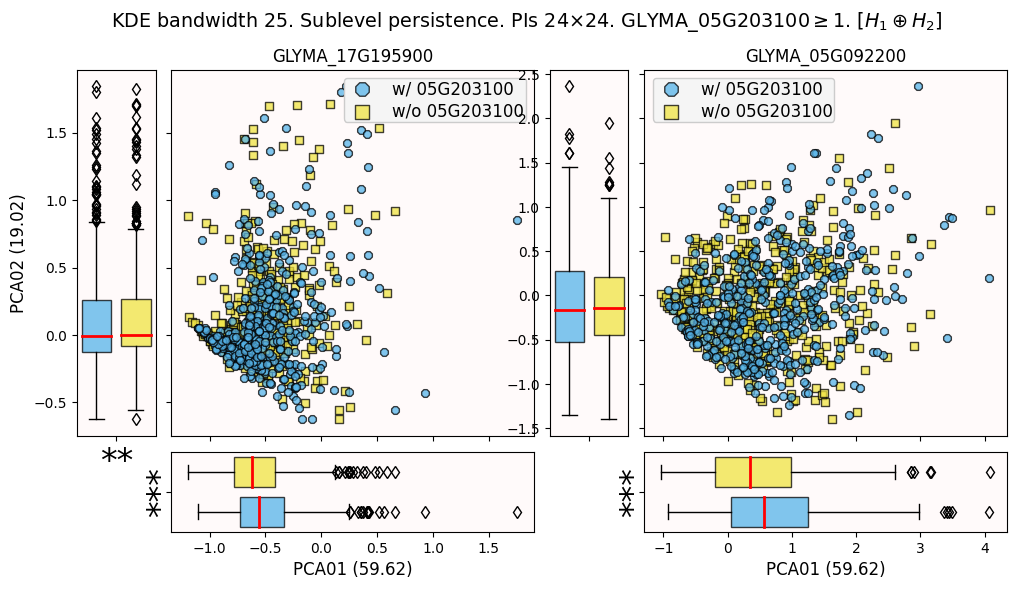

In [49]:
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(5, 10, figure=fig)
fig.add_subplot(gs[:4, 1:5]); fig.add_subplot(gs[:4, 6:])
for i in [0,5]:
    fig.add_subplot(gs[4, i+1:i+5])
    fig.add_subplot(gs[:4, i])
    
for i in range(len(Genes)):
    fig.axes[i].set_title(transcriptomes[Genes[i]], fontsize=fs)
    for j,mask in enumerate([O5G, nonO5G]):
        foo = embedding[embedding['gene_ID'] == Genes[i]].iloc[mask, 2:4]
        fig.axes[i].scatter(*(foo.T.values), marker=marker[j+1], color=color[j], edgecolor='k', label=o5glabels[j+1], alpha=0.75, zorder=2-j)
    fig.axes[i].legend(fontsize=fs, framealpha=1, markerscale=1.75, borderpad=0.1, labelspacing=0.25, facecolor='whitesmoke')
    fig.axes[i].tick_params(bottom=True, labelbottom=False, left=True, labelleft=False)

for i in range(2):
    foo = [ embedding[embedding['gene_ID'] == Genes[i]].iloc[mask, 2:4].values for mask in [O5G, nonO5G] ]
    for j in range(2):
        bplot = fig.axes[2*i + 2+j].boxplot([ bar[:,j] for bar in foo ], sym='d', vert=bool(j), widths=0.75, patch_artist=True, labels=['',''], medianprops={'lw':2,'c':'r'})
        for patch, c in zip(bplot['boxes'], color[:2]):
            patch.set_facecolor(c)
            patch.set_alpha(0.75)
        #fig.axes[2*i + 2+j].tick_params(labelsize=fs)
    fig.axes[2*i+3].set_xticks([1.5], ['*' * (fivegdata.iloc[min5G, 3+6*i: 3+6*i+3] < pvaltol).sum()], fontsize=2*fs, ha='center', va='top')
    fig.axes[2*i+2].set_yticks([1.5], ['*' * (fivegdata.iloc[min5G, 6*i: 6*i+3] < pvaltol).sum()], rotation=90, fontsize=2*fs, ha='center', va='center')
    fig.axes[2*i+2].set_xlabel(embedding.columns[2], fontsize=fs)
    
fig.axes[3].set_ylabel(embedding.columns[3], fontsize=fs)
fig.suptitle(Bname + Gname + Pname , fontsize=1.15*fs)

for i in range(len(fig.axes)):
    fig.axes[i].set_facecolor('snow')

filename = dsrc + bname + pname + '_{}_{}_{}_pca_{}'.format(min5G+1, *transcriptomes[Genes[[gi,gj]]], full_id_gene)
print(filename)

../infected_focus_summer24/D2/G2_sublevel_both_step3_bw25/scale24_-_PI_1_1_1_H1+2_1_GLYMA_17G195900_GLYMA_05G092200_pc_vs_pc_GLYMA_05G203100


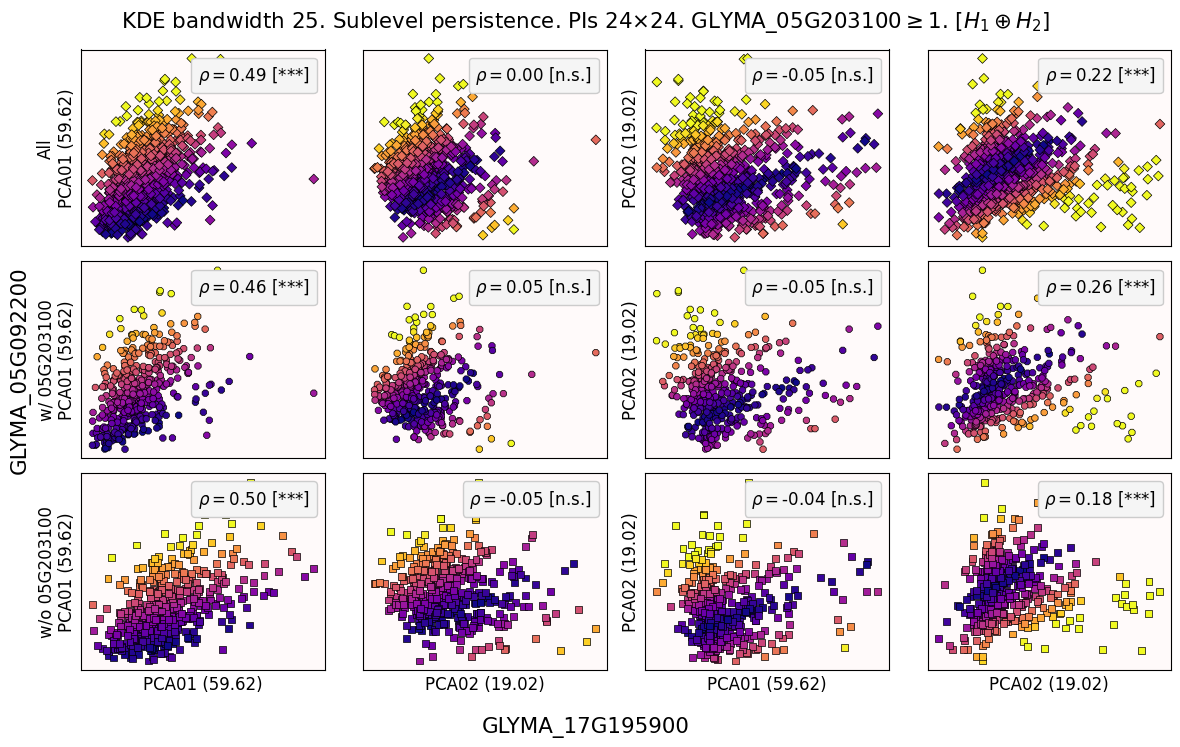

In [50]:
fig, ax = plt.subplots(3,4, figsize=(12,7.5), sharex=False, sharey=False)
for i in range(4):
    ax[-1,i].set_xlabel(embedding.columns[2+i%2], fontsize=fs)

ct = 0
for j,mask in enumerate([np.ones(len(merge),dtype=bool), O5G, nonO5G]):
    ax[j,0].set_ylabel(o5glabels[j] + '\n' +embedding.columns[2], fontsize=fs)
    ax[j,2].set_ylabel(embedding.columns[3], fontsize=fs)
    for it in itertools.product(range(2), repeat=2):
        k = 2*it[0] + it[1]
        
        pca_comp = merge.loc[mask, [ embedding.columns[2 + it[i]]+'_{}'.format(i) for i in range(2)] ]
        diff = np.abs(np.subtract(*(pca_comp.T.values)))
        vmin = utils.minimum_qq_size( diff, alpha=0.25, iqr_factor=1.5)
        vmax = utils.maximum_qq_size( diff, alpha=0.25, iqr_factor=1.5)
        
        corr = fivegdata.iloc[min5G, 12+2*ct]
        expo = utils.signifscalar(fivegdata.iloc[min5G, 12+2*ct+1])
        ct += 1
        ll = '$\\rho = ${:.2f} [{}]'.format(corr, expo)
            
        ax[j,k].scatter(pca_comp.iloc[:,0], pca_comp.iloc[:,1], c=diff, cmap='plasma', marker=marker[j],
                         edgecolor='black', linewidth=0.5, zorder=2, s=25, vmin=vmin, vmax=vmax, label=ll)
        ax[j,k].legend(fontsize=fs, handlelength=0, handletextpad=0, loc='upper right', markerscale=0, framealpha=1, facecolor='whitesmoke')

for a in ax.ravel():
    a.set_facecolor('snow')
    a.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

fig.supxlabel(transcriptomes[Genes[gi]], fontsize=1.28*fs)
fig.supylabel(transcriptomes[Genes[gj]], fontsize=1.28*fs)
fig.suptitle(Bname + Gname + Pname , fontsize=1.28*fs)

fig.tight_layout();
filename = dsrc + bname + pname + '_{}_{}_{}_pc_vs_pc_{}'.format(min5G+1, *transcriptomes[Genes[[gi,gj]]], full_id_gene)
print(filename)
#plt.savefig(filename, dpi=dpi, bbox_inches='tight', pil_kwargs={'optimize':True})

../infected_focus_summer24/D2/G2_sublevel_both_step3_bw25/scale24_-_PI_1_1_1_H1+2_1_GLYMA_17G195900_GLYMA_05G092200_ecc_GLYMA_05G203100


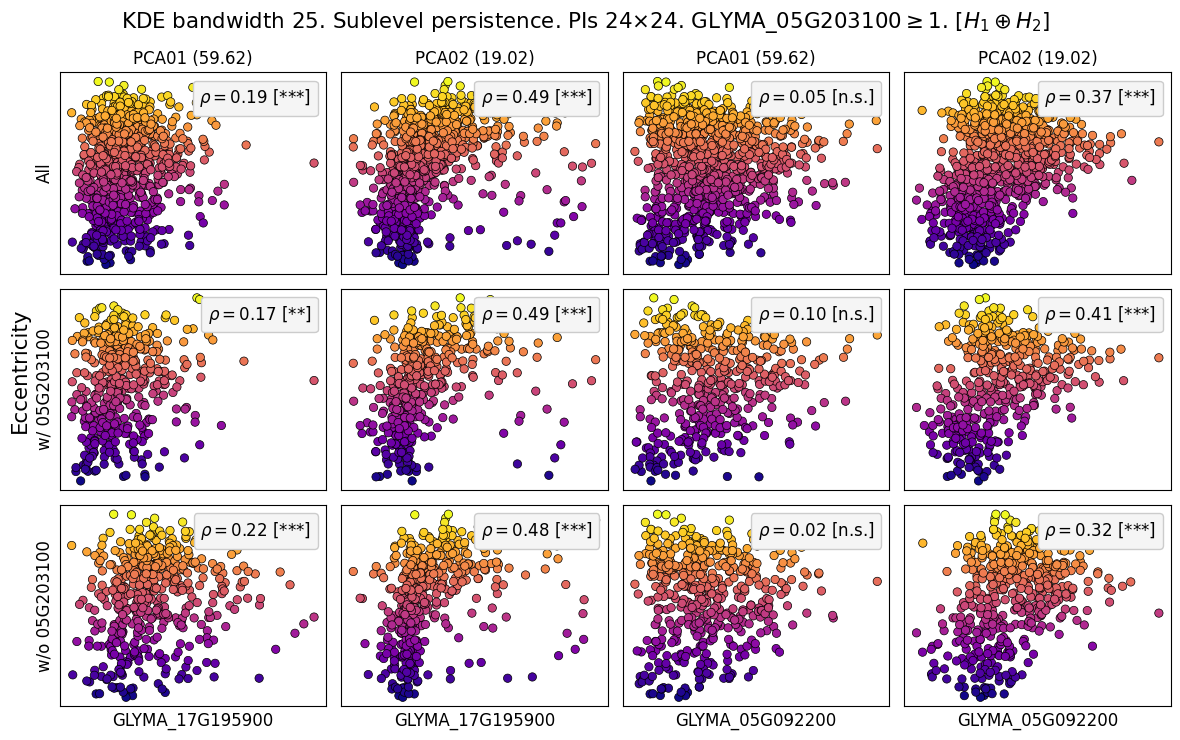

In [63]:
fig, ax = plt.subplots(3,4, figsize=(12,7.5), sharex=False, sharey=False)

for j, gidx in enumerate([gi,gj]):
    for k in range(2):
        it = (0 , 2*j+k)
        ax[it].set_title(embedding.columns[2+k], fontsize=fs)
        ax[-1, 2*j+k].set_xlabel(transcriptomes[Genes[gidx]], fontsize=fs)
ct = 0
for i,mask in enumerate([np.ones(len(merge),dtype=bool), O5G, nonO5G]):
    ax[i,0].set_ylabel(o5glabels[i], fontsize=fs)
    for j, gidx in enumerate([gi,gj]):
        pmask = embedding['gene_ID'] == Genes[gidx]
        for k in range(2):
            it = (i , 2*j+k)
            c = pca[pmask, k][mask]
            diff = np.abs(np.subtract(c, ecc[mask]))
            corr = fivegdata.iloc[min5G, 36+2*ct]
            expo = utils.signifscalar(fivegdata.iloc[min5G, 36+2*ct+1])
            ct += 1
            ll = '$\\rho = ${:.2f} [{}]'.format(corr, expo)
            ax[it].scatter(c, ecc[mask], c=diff, cmap=Cmap, marker='o', edgecolor='black', linewidth=0.5, label=ll)
            ax[it].legend(fontsize=fs, handlelength=0, handletextpad=0, loc='upper right', markerscale=0, framealpha=1, facecolor='whitesmoke')
            ax[it].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

fig.suptitle(Bname + Gname + Pname , fontsize=1.28*fs)
fig.supylabel('Eccentricity', fontsize=1.28*fs)

fig.tight_layout();
filename = dsrc + bname + pname + '_{}_{}_{}_ecc_{}'.format(min5G+1, *transcriptomes[Genes[[gi,gj]]], full_id_gene)
print(filename)
#plt.savefig(filename, dpi=dpi, bbox_inches='tight', pil_kwargs={'optimize':True})

In [249]:
lt_mask = np.any(maxlife > minlife, axis=2)
gmask, cmask = np.nonzero(lt_mask)

bsummary = pd.DataFrame()
bsummary['gene_ID'] = Genes[gmask]
bsummary['ndimage_ID'] = Cells[cmask]

'scale24_-_PI_1_1_1_'

In [252]:

filename

'../infected_focus_summer24/D2/G2_sublevel_both_step3_bw15/scale24_-_PI_1_1_1_H1+2_GLYMA_17G195900_GLYMA_05G092200_ecc_GLYMA_05G203100'

# Explore